# AtomMan Stroh Class

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-03-31

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

Return to the [main atomman page](https://github.com/usnistgov/atomman).

## Introduction

The atomman.defect.Stroh class solves the Eshelby anisotropic elasticity solution for a perfectly straight dislocation or crack using the Stroh method. This allows for the evaluation of a dislocation's elastic energy, as well as the ability to generate a dislocation monopole system. 

The underlying code can be found in [atomman/defect/Stroh.py](https://github.com/usnistgov/atomman/blob/master/atomman/defect/Stroh.py).

- - -

__Library Imports__

In [1]:
%matplotlib inline

import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

import numpy as np

import matplotlib.pyplot as plt

## 1. Parameters

In this section, we define the necessary input parameters.

Define the crystal structure lattice and elastic parameters.
Values here are for fcc Al using the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe at 0 K and 0 pressure.

In [2]:
energy_unit = 'eV'
length_unit = 'angstrom'
pressure_unit = 'GPa'

a = uc.set_in_units(4.05, length_unit)
c11 = uc.set_in_units( 110.53, pressure_unit )
c12 = uc.set_in_units( 60.90, pressure_unit )
c44 = uc.set_in_units(  28.39, pressure_unit )

Define the necessary dislocation-specific parameters.  

- __bugers__: the burgers vector for the dislocation.  This is given in crystallographic terms. 

- __axes__: the three cubic crystallographic axes to associate with the system's x, y, and z directions. The three axes must be orthogonal and right-handed.  The system is created such that the dislocation's line is parallel to the z-axis and y is perpendicular to the slip plane.  For dislocations, the Burgers vector must be in the xz-plane, otherwise a crack will be created.

- __shift__: atomic shift to apply to the system such that the dislocation line is positioned roughly halfway between atomic planes. The Stroh calculation is singular for positions where y=0.

__Note__: The Stroh analysis code should work for all crystal systems not just cubic. However, only cubic systems have been tested so far.  This means that (for now) the definition of axes is focused on cubic systems, and the orientation of the dislocation line, slip planes are fixed.   

In [3]:
#Burgers vector for a fcc edge dislocation: a/2 [ 1 0 -1].
burgers = a / 2 * np.array([ 1.0, 0.0,-1.0])

#Axes orientation to orient the system.
axes = np.array([[ 1, 0,-1],
                 [ 1, 1, 1],
                 [ 1,-2, 1]])

#Position shift to apply when creating the system.  
shift = np.array([0.12500000000000, 0.50000000000000, 0.00000000000000])

## 2. Solve the Stroh Problem

Initiating an instance of Stroh class will automatically obtain a solution using the Stroh method.  Alternatively, a new solution can be obtained by calling the solve() method.  Initilization and solve() have the same arguments:

- __C__: an instance of [atomman.tools.ElasticConstants](https://github.com/usnistgov/atomman/blob/master/Notebooks/atomman.tools.ElasticConstants.ipynb).  

- __burgers__: the 3D Burgers vector.

- __axes__: a 3x3 array of three right-handed orthogonal vectors. If given, the vectors are normalized to obtain a transformation matrix, and then C and burgers are transformed accordingly. If not given, C and burgers are used as is. 

- __tol__: a rounding tolerance for rounding away the precision error imaginary components from returned values that should be real. Optional, in case issues arise.

In [4]:
#initialize an ElasicConstants object
c = am.tools.ElasticConstants(C11 = c11, C12 = c12, C44 = c44)

#initilize a Stroh object
stroh = am.defect.Stroh(c, burgers, axes)

## 3. Stroh.preln

The strain energy around a linear defect is given by:

E(r) = &alpha; * ln(r/r<sub>0</sub>) + E(r<sub>0</sub>)

Here:

- E(r) is the energy per unit length of the material within a cylinder of radius r.

- E(r<sub>0</sub>) is the energy per unit length of the material within a smaller cylinder of radius r<sub>0</sub>.

Mathematically, r<sub>0</sub> cannot go to zero as the energy would be infinite. Practically, elasticity theory breaks down near the defect center, and specific values of r<sub>0</sub> and E(r<sub>0</sub>) are taken to be the core radius and core energy, respectively.

The Stroh analysis provides a solution for &alpha;, which can be obtained with preln.

In [5]:
alpha = stroh.preln

e_l_unit = energy_unit + '/' + length_unit
print "alpha =", uc.get_in_units(alpha, e_l_unit), e_l_unit

alpha = 0.167237605086 eV/angstrom


## 4. Stroh.displacement()

The Stroh displacement solution can be computed for a single position, or for a list of positions.  This can then be used to generate a system containing a dislocation monopole.

### 4.1 Test Stroh.displacement() for a single point

In [6]:
pos_test = uc.set_in_units(np.array([12.4, 13.5, -10.6]), length_unit)

disp = stroh.displacement(pos_test)
print "displacement =", uc.get_in_units(disp, length_unit), length_unit

displacement = [ 0.55272141 -0.13195351 -0.00954374] angstrom


### 4.2. Generate a defect-free system

In [7]:
#fcc unit cell
box = am.Box(a=a, b=a, c=a)
atoms = am.Atoms(natoms=4, prop={'atype':[1,1,1,1],
                                 'pos':[[0.0, 0.0, 0.0],
                                        [0.5, 0.5, 0.0],
                                        [0.0, 0.5, 0.5],
                                        [0.5, 0.0, 0.5]]})
ucell = am.System(atoms=atoms, box=box, scale=True)

#rotate to the specified axes
ucell = am.tools.rotate_cubic(ucell, axes)

#shift positions
pos = ucell.atoms_prop(key='pos') + np.array([ucell.box.a * shift[0],
                                              ucell.box.b * shift[1],
                                              ucell.box.c * shift[2]])
ucell.atoms_prop(key='pos', value=pos)

#Make larger system
system = am.tools.supersize(ucell, (-7, 7), (-6, 6), (0, 1))
print "The generated system has", system.natoms, "atoms."

The generated system has 4032 atoms.


### 4.3 Create dislocation monopole system

In [8]:
#compute the displacement for all atom positions
disp = stroh.displacement(system.atoms_prop(key='pos'))

#shift the atom positions by disp
system.atoms_prop(key='pos', value = system.atoms_prop(key='pos') + disp)

#Change x, y boundaries to non-periodic and call wrap
system.pbc = (False, False, True)
system.wrap()

### 4.4 Plot atom positions

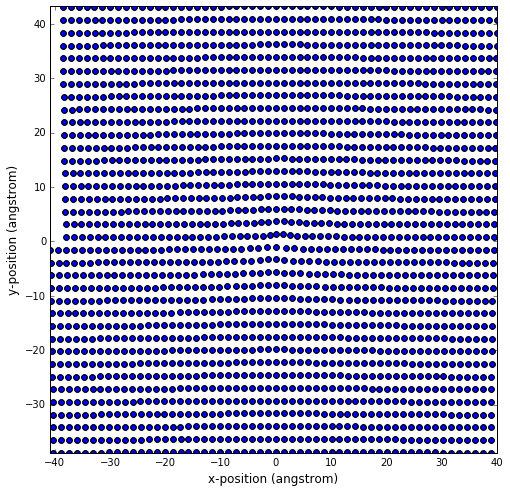

In [9]:
pos = system.atoms_prop(key='pos')
x = uc.get_in_units(pos[:,0], length_unit)
y = uc.get_in_units(pos[:,1], length_unit)
plt.figure(figsize=(8,8))
plt.scatter(x, y, s=30)

plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.xlabel('x-position ('+length_unit+')', fontsize='large')
plt.ylabel('y-position ('+length_unit+')', fontsize='large')


plt.show()

## 5. Stroh.stress()

The Stroh stress solution can be computed for a single position, or for a list of positions.

### 4.1 Test Stroh.stress() for a single point

In [10]:
pos_test = uc.set_in_units(np.array([12.4, 13.5, -10.6]), length_unit)

stress = stroh.stress(pos_test)
print "stress ="
print uc.get_in_units(stress, pressure_unit), pressure_unit

stress =
[[-1.43599989 -0.05430581  0.01806795]
 [-0.05430581 -0.05912326  0.01967075]
 [ 0.01806795  0.01967075 -0.53062593]] GPa


### 4.2 Compute stress for atom positions in system

In [11]:
stress = stroh.stress(system.atoms_prop(key='pos'))
system.atoms_prop(key='stress', value=stress)

### 4.3 Plot positions with color for stress_xx

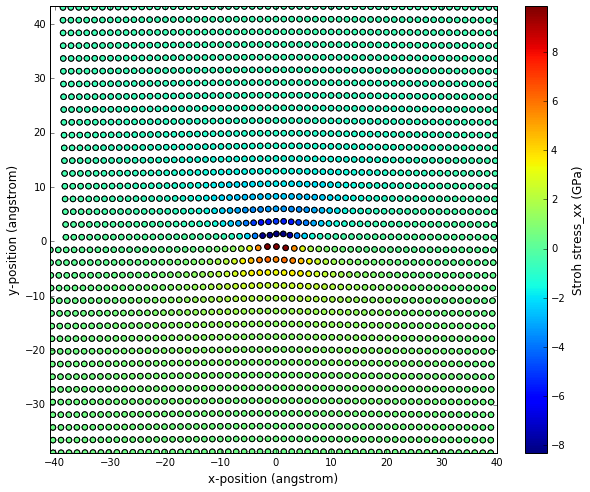

In [12]:
pos = system.atoms_prop(key='pos')
x = uc.get_in_units(pos[:,0], length_unit)
y = uc.get_in_units(pos[:,1], length_unit)
c = uc.get_in_units(stress[:,0,0], pressure_unit)

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('jet')
sc = plt.scatter(x, y, c=c, vmin=min(c)/2, vmax=max(c)/2, s=30, cmap=cm)
plt.colorbar(sc).set_label('Stroh stress_xx ('+pressure_unit+')', fontsize='large')

plt.xlim(min(x),max(x))
plt.ylim(min(y), max(y))
plt.xlabel('x-position ('+length_unit+')', fontsize='large')
plt.ylabel('y-position ('+length_unit+')', fontsize='large')
plt.show()